<h2> UMAP vs T-SNE</h2>
This notebook reviews how UMAP and T-SNE both perform on a Telco Customer Churn dataset. The underlying classification task is predicting customers <br>
who might churn. We will use it instead to determine if we can detect clusters within the data. <br> 

Link - https://www.kaggle.com/blastchar/telco-customer-churn

In [63]:
# Standard Libraries
import pandas as pd
import numpy as np

import plot_clustering_plots as plot_clusters

from datetime import datetime
import itertools
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

import os
import warnings

# Viz Libraries
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.manifold import TSNE
import umap

from pathlib import Path
from os.path import join

from numpy.random import choice, randint, uniform, randn
import seaborn as sns
import matplotlib.pyplot as plt

import ipyvolume as ipv
from sklearn.datasets import fetch_openml, make_swiss_roll, make_blobs

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import category_encoders as ce
from warnings import simplefilter

import colorlover as cl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
# scientific notation
pd.options.display.float_format = '{:.2f}'.format

# helper functions used throughout this project
print_header = lambda msg: print(f"{msg}\n{'-'*len(msg)}")

In [3]:
notebook_start_time = datetime.now()

In [4]:
# global variables
CPU_COUNT = -1

In [5]:
# load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# change all column names to lower case
df.columns = map(str.lower, df.columns)

# calculate the shape of the data
df.shape

(7043, 21)

In [6]:
# time how long the conversion takes
# start_time = datetime.now()

### Exploratory Data Analysis
We will perform some basic EDA to determine any pre-processing steps we need to perform to get the data in the right shape. <br>
We are looking for missing values, type of data types present, presence of categorical features, numerical features and how much they differ between each other etc. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [8]:
# describe non-numeric features in the dataset
df.describe(include=[object]) 

,customerid,gender,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,totalcharges,churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3750-CKVKH,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


We can see that most of our features are categorical in nature with between 2 to 4 unique features. <br>
'totalcharges' however needs further analysis as it is showing as an object data type while having 1707 unique features (high cardinality) 

We will first try to first convert it to a numerica datatype and see if its simply a matter of being assigned the wrong data type

In [9]:
# df['totalcharges'] = df['totalcharges'].astype(float)

We get an error of 'ValueError: could not convert string to float: '' when we attempt to convert the data type to numeric, signaling that there is a string value hidden underneath <br>

We will have to find any spaces in any of the fields and replace them with 0 as shown below. 

In [10]:
# clearn totalcharges
df['totalcharges'] = df['totalcharges'].replace({" ":'0'})
df['totalcharges'] = df['totalcharges'].astype(float)

That works as we now have totalchargers with the correct data type

In [11]:
df['totalcharges'].dtypes

dtype('float64')

Let's now look at the numeric features using the describe function. It will only show numeric features by default, hence why we ran it explicitly pass object previously.

In [12]:
df.describe()

,seniorcitizen,tenure,monthlycharges,totalcharges
count,7043.00,7043.00,7043.00,7043.00
mean,0.16,32.37,64.76,2279.73
std,0.37,24.56,30.09,2266.79
min,0.00,0.00,18.25,0.00
25%,0.00,9.00,35.50,398.55
50%,0.00,29.00,70.35,1394.55
75%,0.00,55.00,89.85,3786.60
max,1.00,72.00,118.75,8684.80


We dont see any negative values although there might be outliers in totalcharges. We will run a function to determine if any of the outliers are significant enough for us to eliminate them further down. 

Histograms below will help us review how the numeric fields are distributed. 

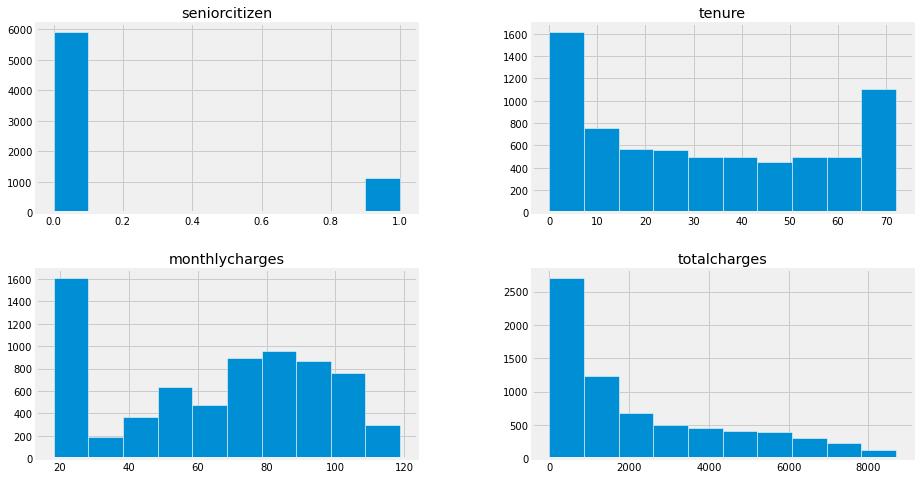

In [13]:
df[['seniorcitizen','tenure','monthlycharges', 'totalcharges']].hist(edgecolor="white",bins=10,figsize=(14,8));

### Label Encoder
We will convert our target variable using labelencoder to change the values from 'Yes' and 'No' to 1 and 0

In [14]:
le = preprocessing.LabelEncoder()

In [15]:
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [16]:
df['churn'] = le.fit_transform(df['churn'])

In [17]:
df.churn.value_counts()

0    5174
1    1869
Name: churn, dtype: int64

We will drop customerid at this point due to its high cardinality and the fact that it might not be that informative to our clustering goal

In [18]:
df.drop(['customerid'], inplace=True, axis=1)

#### Find Duplicates
We will see if there are any duplicates in the data. Duplicates can only degrade your algorithm by acting as nonrandom sampling observations that would lead to biasing your model.

In [19]:
df.shape

(7043, 20)

In [20]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [21]:
df.shape

(7021, 20)

From the new shape above, it seems as if there were 5 duplicates that were dropped

#### Encode Categorical Variables
At this point we need to convert our categorical features to numeric values. Most algorithms, including the ones we are about to experiment with do not handle categorical features. 

In [22]:
# lets retrieve all the columns that can be considered categorical. We already saw this list using the describe function earlier. 
cat_features = df.select_dtypes(include = ['object']).columns.tolist()

In [23]:
cat_features

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

In [24]:
df.describe(include=[object]) 

,gender,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod
count,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,3541,3619,4911,6339,3368,3090,3490,3080,3087,3465,2802,2777,3853,4161,2359


In [25]:
# drop our target feature
X_train = df.drop('churn', axis=1)
# save our target feature in a y variable
y_train = df.churn

We will use JamesSteinEncoder to encoder our categrical features to numeric. Why JamesStein?

In [26]:
# use binary encoding to encode two categorical features
encoder = ce.JamesSteinEncoder(cols=cat_features)

In [28]:
# fit_tranform dataframe
X_train = encoder.fit_transform(X_train, y_train)

In [29]:
df = X_train.merge(y_train, on= X_train.index)
# drop the index feature key_0
df.drop("key_0", axis=1, inplace=True)

In [30]:
cat_features.append('churn')

In [31]:
cat_features.append('seniorcitizen')

In [32]:
df[cat_features] = df[cat_features].astype('category')

In [33]:
df.sample(3)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
2242,0.27,0,0.33,0.31,40,0.27,0.25,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.03,0.16,0.17,19.65,830.25,0
6631,0.26,0,0.20,0.15,6,0.27,0.25,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.43,0.16,0.17,19.85,138.85,0
3780,0.26,0,0.33,0.31,9,0.27,0.25,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.43,0.16,0.20,19.85,178.80,0


### Determine Low Variance Features

In [34]:
unique_counts = df.nunique()

In [35]:
# calculate unique counts in each column
unique_stats = pd.DataFrame(unique_counts).rename(columns={'index': 'feature', 0: 'nunique'}).sort_values('nunique', ascending=True)

In [36]:
# find columns with only one unique count
record_single_unique = pd.DataFrame(unique_counts[unique_counts < 2]).reset_index().rename(columns={'index': 'feature', 0: 'nunique'})

In [37]:
# store features to drop in a list
non_unique_to_drop = list(record_single_unique['feature'])

In [38]:
non_unique_to_drop

[]

None of the features have similar values

### Drop Highly Correlated Features

In [39]:
# threshold
threshold = 90

In [40]:
# create a correlation matrix on the dataset
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

In [41]:
# find index of feature columns with correlation greater  than 90
correlated_features = [column for column in upper.columns if any(upper[column] > threshold)]

In [42]:
correlated_features

[]

None of the features are highly correlated (at least above 90)

### Split between depenendent and independent features

### Scaling Features

In [43]:
df.sample(3)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
148,0.26,0,0.33,0.15,30,0.27,0.25,0.19,0.42,0.22,0.23,0.42,0.30,0.33,0.11,0.16,0.17,64.50,1929.95,0
1381,0.27,0,0.33,0.31,1,0.27,0.29,0.19,0.42,0.40,0.39,0.42,0.33,0.33,0.43,0.33,0.18,49.95,49.95,1
3457,0.26,0,0.33,0.31,4,0.27,0.25,0.19,0.42,0.40,0.39,0.42,0.33,0.33,0.43,0.33,0.42,45.90,199.75,0


In [44]:
# drop our target feature
X_train = df.drop('churn', axis=1)
# save our target feature in a y variable
y_train = df.churn

In [45]:
scaler = StandardScaler()
numeric= ['tenure','monthlycharges','totalcharges']
X_train[numeric] = scaler.fit_transform(X_train[numeric].to_numpy())

In [46]:
X_train.sample(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
5083,0.27,0,0.33,0.31,1.33,0.27,0.29,0.42,0.15,0.22,0.39,0.15,0.33,0.33,0.11,0.33,0.42,0.83,1.57
3722,0.27,0,0.20,0.31,1.00,0.27,0.29,0.42,0.42,0.22,0.23,0.42,0.30,0.30,0.43,0.33,0.17,1.32,1.60


#### Merge back dataframe

In [47]:
df = X_train.merge(y_train, on= X_train.index)
# drop the index feature key_0
df.drop("key_0", axis=1, inplace=True)
df.shape

(7021, 20)

### Look for Outliers

In [48]:
df.shape

(7021, 20)

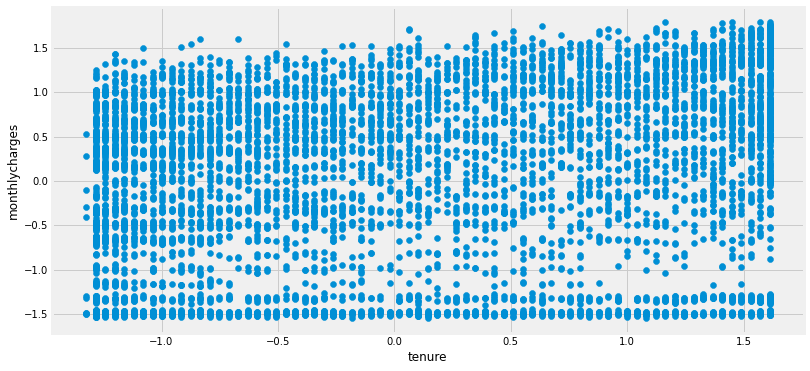

In [49]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['tenure'], df['monthlycharges'])
ax.set_xlabel('tenure')
ax.set_ylabel('monthlycharges')
plt.show();

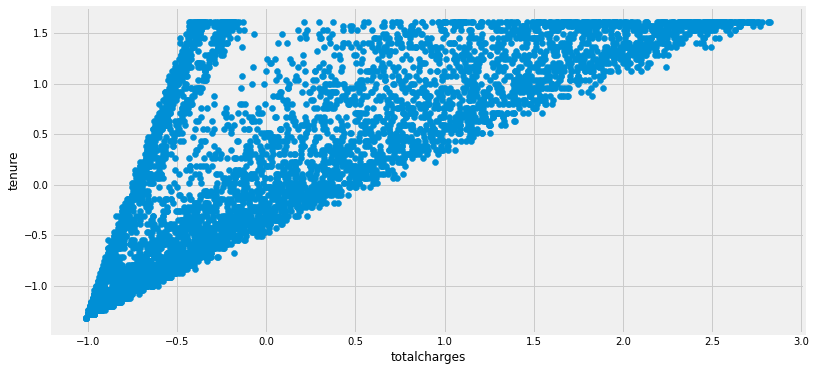

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['totalcharges'], df['tenure'])
ax.set_xlabel('totalcharges')
ax.set_ylabel('tenure')
plt.show();

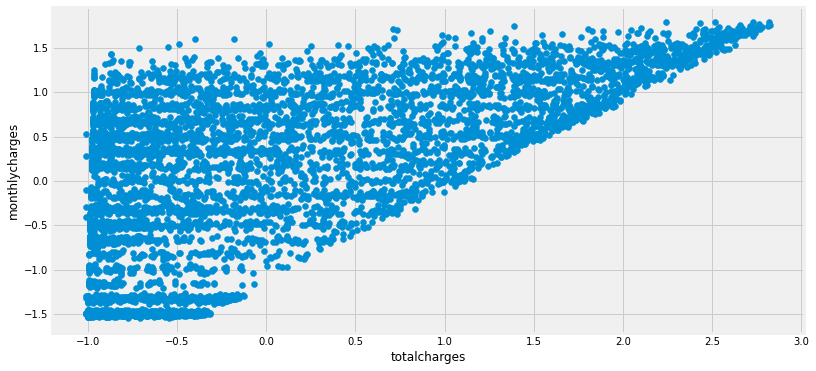

In [51]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['totalcharges'], df['monthlycharges'])
ax.set_xlabel('totalcharges')
ax.set_ylabel('monthlycharges')
plt.show();

There are no significant outliers that need to be removed from the dataset

## Reduce Dimensions using PCA First
We first reduce the dimensions using PCA before feeding the resulting dataset to our umap and t-SNE algorithms

#### Determine # of Principal Components using K-Means

## UMAP Clustering 
We first reduce the dimensions using PCA before feeding the resulting dataset to our t-SNE algorithm

In [52]:
x_train_pca = df.copy()

In [53]:
# import UMAP library
import umap.umap_ as umap

In [54]:
# time how long the conversion takes
start_time = datetime.now()

In [55]:
# we will try out different values for n_neighbors and see which gives us the best clusters
n_neighbors = [10,20,30]
distance = 0.5

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Neighbor_Value 10')

<AxesSubplot:title={'center':'Neighbor_Value 10'}, xlabel='vector_one', ylabel='vector_two'>

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Neighbor_Value 20')

<AxesSubplot:title={'center':'Neighbor_Value 20'}, xlabel='vector_one', ylabel='vector_two'>

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Neighbor_Value 30')

<AxesSubplot:title={'center':'Neighbor_Value 30'}, xlabel='vector_one', ylabel='vector_two'>

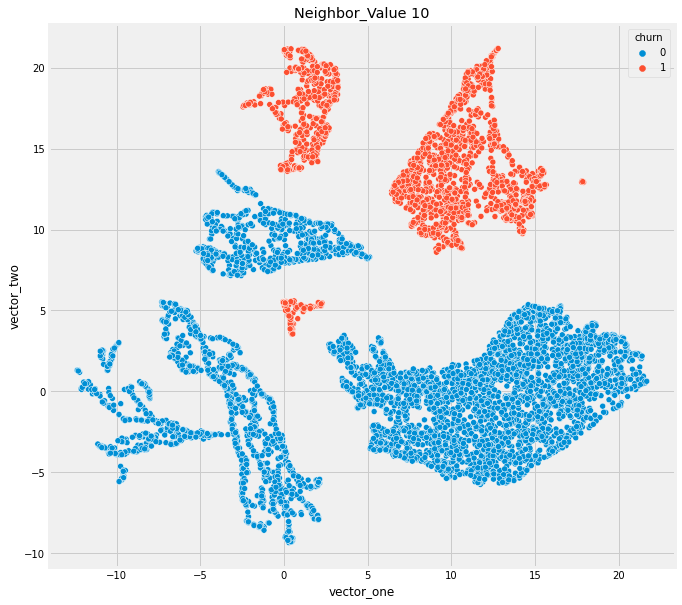

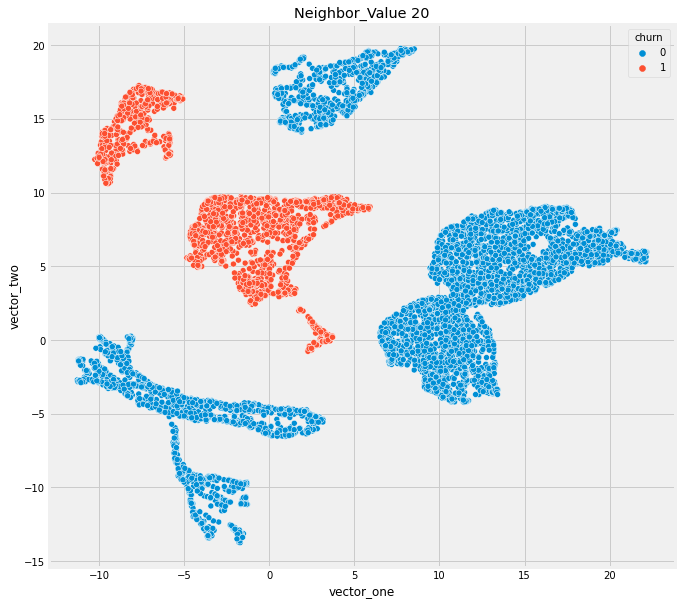

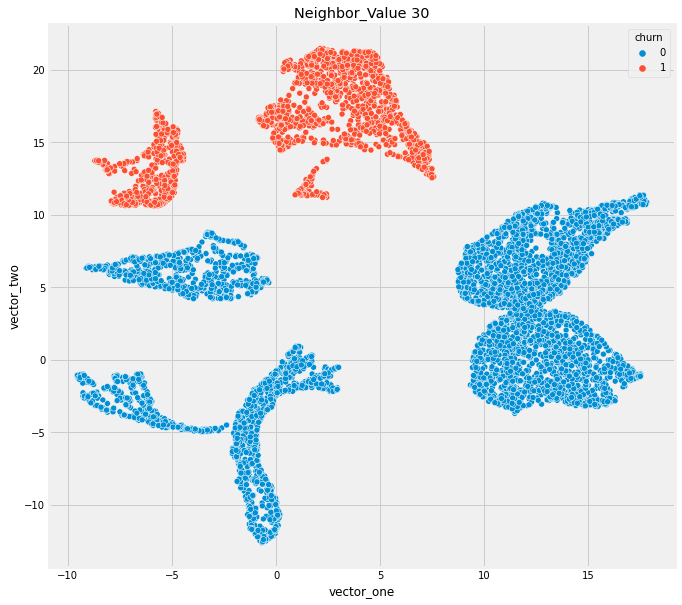

In [56]:
# simple for loop generating the UMAP clusters
for neighbor in n_neighbors:
    reducer = umap.UMAP(n_neighbors=neighbor,min_dist=distance)
    X_train_umap = reducer.fit_transform(x_train_pca)
    X_train_umap = pd.DataFrame(data=X_train_umap, columns=['vector_one','vector_two'])
    X_train_umap = X_train_umap.merge(y_train,on=y_train.index)
    X_train_umap.drop("key_0", axis=1, inplace=True)
    n_neighbors_value = str(neighbor)
    # plot scatter plot
    plt.figure(figsize=(10,10));
    plt.title("Neighbor_Value " +n_neighbors_value);
    sns.scatterplot(x="vector_one",y="vector_two",hue="churn",data=X_train_umap,);

In [57]:
time_elapsed = datetime.now() - start_time
print('UMAP Processing Time (hh:mm:ss.ms) {}'.format(time_elapsed))

UMAP Processing Time (hh:mm:ss.ms) 0:00:42.427111


## t-SNE Clustering 

The darker the color, the more the original column contributes to the component (Harrison, 2019)

In [58]:
# we will try the perplexity values below to determine which ones give us the best clusters
perplexity_values = [10,30,40]

In [59]:
n_components=2
learning_rate=300
perplexity=30
early_exaggeration=12
init='random'
random_state=2019
n_jobs=-1

In [60]:
start_time = datetime.now()

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'TSNE_Perplexity_Value 10')

<AxesSubplot:title={'center':'TSNE_Perplexity_Value 10'}, xlabel='vector_one', ylabel='vector_two'>

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'TSNE_Perplexity_Value 30')

<AxesSubplot:title={'center':'TSNE_Perplexity_Value 30'}, xlabel='vector_one', ylabel='vector_two'>

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'TSNE_Perplexity_Value 40')

<AxesSubplot:title={'center':'TSNE_Perplexity_Value 40'}, xlabel='vector_one', ylabel='vector_two'>

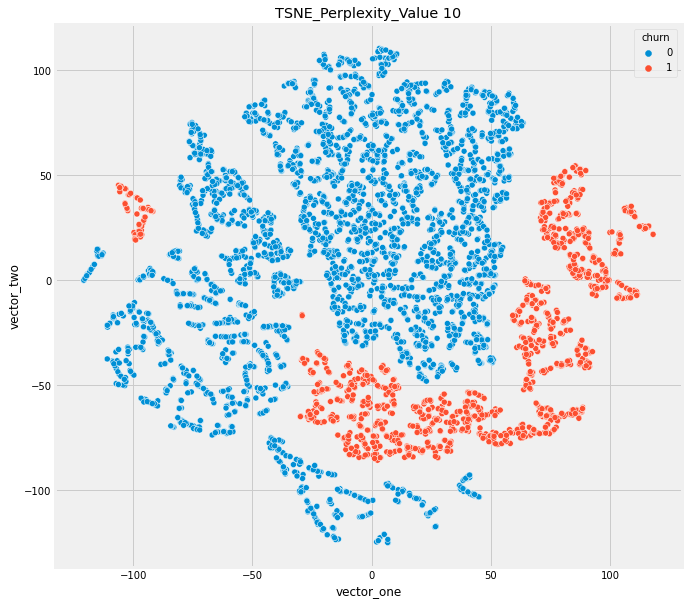

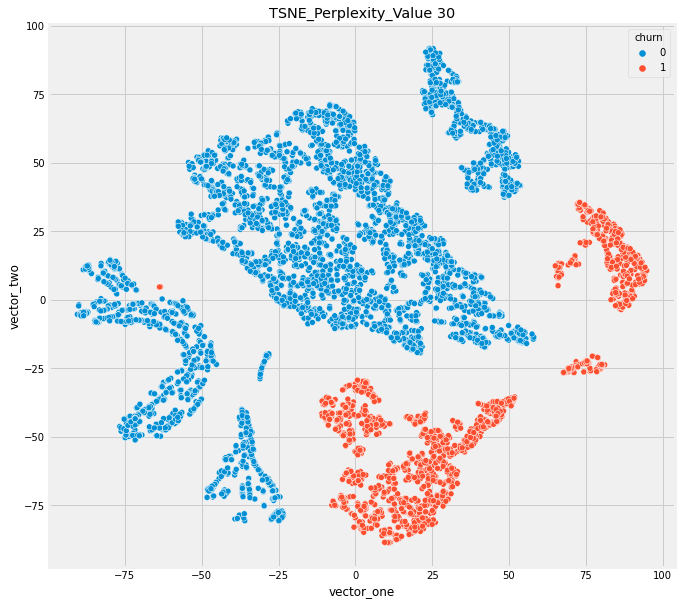

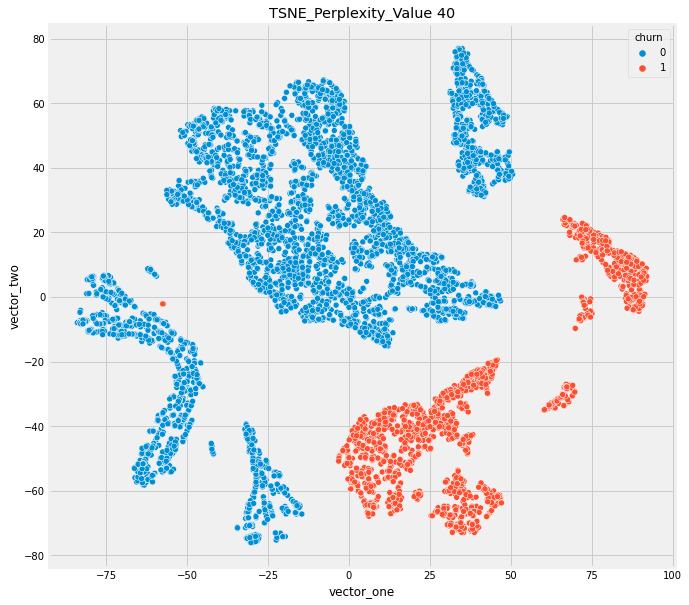

In [61]:
for value in perplexity_values:
    tsne = TSNE(n_components=2, learning_rate=300, perplexity=value, early_exaggeration=12,init='random', random_state=2019)
    X_train_tSNE = tsne.fit_transform(x_train_pca)
    X_train_tSNE = pd.DataFrame(data=X_train_tSNE, columns=['vector_one','vector_two'])
    X_train_tSNE = X_train_tSNE.merge(y_train,on=y_train.index)
    X_train_tSNE.drop("key_0", axis=1, inplace=True)
    perplexity_value = str(value)
    # plot
    plt.figure(figsize=(10,10));
    plt.title("TSNE_Perplexity_Value " + perplexity_value);
    sns.scatterplot(x="vector_one",y="vector_two",hue="churn",data=X_train_tSNE);

In [62]:
time_elapsed = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:01:30.078103


## References

Harrison, M (2019) "Machine Learning Pocket Reference" [online]. O'Reilly Media